In [ ]:
!wget https://s3.us-east-2.amazonaws.com/wrfwindout.d03.1992-01-01/wrftest/wrfwindout_d03_1992_10days.tar.gz
!tar xvzf wrfwindout_d03_1992_10days.tar.gz

--2021-02-23 18:50:58--  https://s3.us-east-2.amazonaws.com/wrfwindout.d03.1992-01-01/wrftest/wrfwindout_d03_1992_10days.tar.gz
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.101.193
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.101.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84398686 (80M) [application/x-gzip]
Saving to: ‘wrfwindout_d03_1992_10days.tar.gz’

wrfwindout_d03_1992 100%[===================>]  80.49M  24.7MB/s    in 3.3s    

2021-02-23 18:51:02 (24.7 MB/s) - ‘wrfwindout_d03_1992_10days.tar.gz’ saved [84398686/84398686]

wrfwindout_d03_1992-01-01_00_00_00
wrfwindout_d03_1992-01-02_00_00_00
wrfwindout_d03_1992-01-03_00_00_00
wrfwindout_d03_1992-01-04_00_00_00
wrfwindout_d03_1992-01-05_00_00_00
wrfwindout_d03_1992-01-06_00_00_00
wrfwindout_d03_1992-01-07_00_00_00
wrfwindout_d03_1992-01-08_00_00_00
wrfwindout_d03_1992-01-09_00_00_00
wrfwindout_d03_1992-01-10_00_00_00


In [ ]:
!pip install netCDF4

     |████████████████████████████████| 4.7MB 12.8MB/s 
     |████████████████████████████████| 317kB 42.5MB/s 


In [ ]:
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
print(np.__version__)

1.19.5


## Check one file (with one-day data)

### Extract the data for timestamps

In [ ]:
fn_windout = "/content/wrfwindout_d03_1992-01-01_00_00_00"
ds_windout = nc.Dataset(fn_windout)

In [ ]:
print(ds_windout.variables.keys())

dict_keys(['Times', 'RHO_HGTM', 'U_HGTM', 'V_HGTM', 'WNDSPD_AVG_100M', 'WNDSPD_AVG_10M'])


In [ ]:
times = ds_windout['Times'][:]
print("Times shape: ", times.shape)
print("Times[2] data: ", times[2].tobytes().decode())

Times shape:  (24, 19)
Times[2] data:  1992-01-01_02:00:00


In [ ]:
ts = []
for t in times:
    tstr = t.tobytes().decode()
    tdts = datetime.strptime(tstr, '%Y-%m-%d_%H:%M:%S')
    ts.append(tdts)
print(ts)

[datetime.datetime(1992, 1, 1, 0, 0), datetime.datetime(1992, 1, 1, 1, 0), datetime.datetime(1992, 1, 1, 2, 0), datetime.datetime(1992, 1, 1, 3, 0), datetime.datetime(1992, 1, 1, 4, 0), datetime.datetime(1992, 1, 1, 5, 0), datetime.datetime(1992, 1, 1, 6, 0), datetime.datetime(1992, 1, 1, 7, 0), datetime.datetime(1992, 1, 1, 8, 0), datetime.datetime(1992, 1, 1, 9, 0), datetime.datetime(1992, 1, 1, 10, 0), datetime.datetime(1992, 1, 1, 11, 0), datetime.datetime(1992, 1, 1, 12, 0), datetime.datetime(1992, 1, 1, 13, 0), datetime.datetime(1992, 1, 1, 14, 0), datetime.datetime(1992, 1, 1, 15, 0), datetime.datetime(1992, 1, 1, 16, 0), datetime.datetime(1992, 1, 1, 17, 0), datetime.datetime(1992, 1, 1, 18, 0), datetime.datetime(1992, 1, 1, 19, 0), datetime.datetime(1992, 1, 1, 20, 0), datetime.datetime(1992, 1, 1, 21, 0), datetime.datetime(1992, 1, 1, 22, 0), datetime.datetime(1992, 1, 1, 23, 0)]


### Wind speed data on one spot without considering neighbors

In [ ]:
wndspd_avg_10m = ds_windout['WNDSPD_AVG_10M'][:]
print('WNDSPD_AVG_10M shape:', wndspd_avg_10m.shape)
print('WNDSPD_AVG_10M at grid index of [100, 90]: \n', wndspd_avg_10m[:,100, 90])

WNDSPD_AVG_10M shape: (24, 144, 138)
WNDSPD_AVG_10M at grid index of [100, 90]: 
 [4.5143094 4.6068125 5.607519  5.845291  5.6617923 5.3598833 4.5652494
 4.6760983 4.524302  4.370231  4.042331  3.5633156 3.2635539 3.518132
 4.0297794 3.777819  3.299952  3.374463  3.2556567 3.926377  4.9187202
 5.3559947 6.2512712 6.864123 ]


In [ ]:
df = pd.DataFrame({'ds':ts, 'y':wndspd_avg_10m[:,100, 90]})
df.head()

,ds,y
0,1992-01-01 00:00:00,4.514309
1,1992-01-01 01:00:00,4.606812
2,1992-01-01 02:00:00,5.607519
3,1992-01-01 03:00:00,5.845291
4,1992-01-01 04:00:00,5.661792


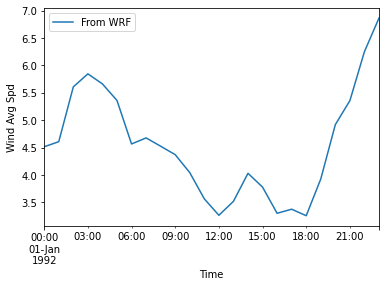

In [ ]:
df.plot(x='ds', y='y')
plt.xlabel('Time')
plt.ylabel("Wind Avg Spd")
plt.legend(['From WRF'])
plt.show()

### Considering Neighbors

In [ ]:
rho_hgtm = ds_windout['RHO_HGTM'][:]
u_hgtm = ds_windout['U_HGTM'][:]
v_hgtm = ds_windout['V_HGTM'][:]
wndspd_avg_10m = ds_windout['WNDSPD_AVG_10M'][:]
wndspd_avg_100m = ds_windout['WNDSPD_AVG_100M'][:]

In [ ]:
nb_layer = 1
i = 100
j = 90

In [ ]:
# Generating the neighboring indices
'''
Example: when nb_layer = 1:
  1 (i-1,j-1)  |  2 (i-1,j)  |   3 (i-1,j+1)
-----------------------------------------------
  4 (i,  j-1)  |  0 (i,  j)  |   5 (i,  j+1)
-----------------------------------------------
  6 (i+1,j-1)  |  7 (i+1,j)  |   8 (i+1,j+1)
 '''
nb_list = [[i, j]] # center grid as element 0

for nbi in np.arange(-nb_layer, nb_layer+1):
  for nbj in np.arange(-nb_layer, nb_layer+1):
    if (nbi==0 and nbj==0): continue
    nb_list = np.append(nb_list, [[i+nbi, j+nbj]], axis=0)
print(nb_list)

[[100  90]
 [ 99  89]
 [ 99  90]
 [ 99  91]
 [100  89]
 [100  91]
 [101  89]
 [101  90]
 [101  91]]


In [ ]:
df = pd.DataFrame({'ds':ts})

for idx in range(len(nb_list)):
    ci = nb_list[idx]
    rho = rho_hgtm[:, ci[0], ci[1]]
    u = u_hgtm[:, ci[0], ci[1]]
    v = v_hgtm[:, ci[0], ci[1]]
    wa = wndspd_avg_100m[:, ci[0], ci[1]]
    df['rho_'+str(idx)] = rho
    df['u_'+str(idx)] = u
    df['v_'+str(idx)] = v
    df['wa_'+str(idx)] = wa
df.head()

,ds,rho_0,u_0,v_0,wa_0,rho_1,u_1,v_1,wa_1,rho_2,u_2,v_2,wa_2,rho_3,u_3,v_3,wa_3,rho_4,u_4,v_4,wa_4,rho_5,u_5,v_5,wa_5,rho_6,u_6,v_6,wa_6,rho_7,u_7,v_7,wa_7,rho_8,u_8,v_8,wa_8
0,1992-01-01 00:00:00,1.131430,-6.258254,-0.662391,6.137932,1.135103,-6.034837,-0.450405,5.861002,1.134012,-6.133881,-0.531081,5.878819,1.133040,-6.185008,-0.621642,5.921554,1.131688,-6.331424,-0.600144,6.223226,1.130805,-6.246516,-0.694190,6.106830,1.126822,-6.508084,-0.662896,6.444704,1.127318,-6.304911,-0.719466,6.274328,1.127363,-6.263430,-0.680336,6.190054
1,1992-01-01 01:00:00,1.132985,-7.354509,-0.901965,6.668013,1.136635,-7.039205,-0.629925,6.372119,1.135700,-7.105494,-0.762597,6.447479,1.134848,-7.229098,-0.882815,6.595722,1.133090,-7.351449,-0.777487,6.688179,1.132482,-7.433272,-0.966665,6.755906,1.128174,-7.545772,-0.874647,6.912114,1.128792,-7.464809,-0.976139,6.800765,1.128958,-7.497114,-0.972461,6.846753
2,1992-01-01 02:00:00,1.135705,-8.324902,-1.278185,8.015716,1.139456,-8.130767,-0.731323,7.727880,1.138522,-8.084369,-0.793804,7.751853,1.137653,-8.142122,-0.865207,7.844580,1.135836,-8.407112,-1.179311,8.047176,1.135182,-8.324851,-1.332862,8.047915,1.131004,-8.617728,-1.655282,8.211569,1.131542,-8.496778,-1.673017,8.121314,1.131664,-8.469800,-1.591590,8.117480
3,1992-01-01 03:00:00,1.138608,-8.048993,-1.097896,8.338034,1.142227,-8.222049,-0.959868,8.245147,1.141279,-8.040666,-0.875497,8.178553,1.140396,-7.948764,-0.799704,8.183114,1.138705,-8.273804,-1.099632,8.449685,1.138087,-7.969768,-1.075851,8.304811,1.133794,-8.296639,-1.512153,8.724327,1.134367,-8.078391,-1.491621,8.557535,1.134490,-8.028662,-1.398801,8.479977
4,1992-01-01 04:00:00,1.140653,-7.803408,-2.030352,8.056617,1.144496,-7.824979,-1.710499,8.194478,1.143516,-7.677676,-1.654038,7.978544,1.142567,-7.682670,-1.661501,7.902620,1.140814,-7.908365,-1.997609,8.258303,1.140075,-7.830942,-2.030288,8.007588,1.135696,-7.972743,-2.490464,8.346336,1.136249,-7.784311,-2.466712,8.131044,1.136346,-7.744304,-2.262531,8.051309


In [ ]:
cols = [col for col in df.columns if col not in ['ds']]
print(cols)

['rho_0', 'u_0', 'v_0', 'wa_0', 'rho_1', 'u_1', 'v_1', 'wa_1', 'rho_2', 'u_2', 'v_2', 'wa_2', 'rho_3', 'u_3', 'v_3', 'wa_3', 'rho_4', 'u_4', 'v_4', 'wa_4', 'rho_5', 'u_5', 'v_5', 'wa_5', 'rho_6', 'u_6', 'v_6', 'wa_6', 'rho_7', 'u_7', 'v_7', 'wa_7', 'rho_8', 'u_8', 'v_8', 'wa_8']


## Time Series Data Aggregation from multiple files

In [ ]:
import os
dir='/content/'
pattern = 'wrfwindout_d03_1992-01' 
matching_files = [f for f in os.listdir(dir) if pattern in f]
matching_files.sort()
print(matching_files)

['wrfwindout_d03_1992-01-01_00_00_00', 'wrfwindout_d03_1992-01-02_00_00_00', 'wrfwindout_d03_1992-01-03_00_00_00', 'wrfwindout_d03_1992-01-04_00_00_00', 'wrfwindout_d03_1992-01-05_00_00_00', 'wrfwindout_d03_1992-01-06_00_00_00', 'wrfwindout_d03_1992-01-07_00_00_00', 'wrfwindout_d03_1992-01-08_00_00_00', 'wrfwindout_d03_1992-01-09_00_00_00', 'wrfwindout_d03_1992-01-10_00_00_00']


In [ ]:
nb_layer = 1
i = 100
j = 90

In [ ]:
# Generating the neighboring indices
'''
Example: when nb_layer = 1:
  1 (i-1,j-1)  |  2 (i-1,j)  |   3 (i-1,j+1)
-----------------------------------------------
  4 (i,  j-1)  |  0 (i,  j)  |   5 (i,  j+1)
-----------------------------------------------
  6 (i+1,j-1)  |  7 (i+1,j)  |   8 (i+1,j+1)
 '''
nb_list = [[i, j]] # center grid as element 0

for nbi in np.arange(-nb_layer, nb_layer+1):
  for nbj in np.arange(-nb_layer, nb_layer+1):
    if (nbi==0 and nbj==0): continue
    nb_list = np.append(nb_list, [[i+nbi, j+nbj]], axis=0)

In [ ]:
df = pd.DataFrame() 

for fn_windout in matching_files:

  ds_windout = nc.Dataset(dir+fn_windout)

  times = ds_windout['Times'][:]
  ts = []
  for t in times:
    tstr = t.tobytes().decode()
    tdts = datetime.strptime(tstr, '%Y-%m-%d_%H:%M:%S')
    ts.append(tdts)

  rho_hgtm = ds_windout['RHO_HGTM'][:]
  u_hgtm = ds_windout['U_HGTM'][:]
  v_hgtm = ds_windout['V_HGTM'][:]
  wndspd_avg_10m = ds_windout['WNDSPD_AVG_10M'][:]
  wndspd_avg_100m = ds_windout['WNDSPD_AVG_100M'][:]

  dfi = pd.DataFrame({'ds':ts})

  for idx in range(len(nb_list)):
    ci = nb_list[idx]
    rho = rho_hgtm[:, ci[0], ci[1]]
    u = u_hgtm[:, ci[0], ci[1]]
    v = v_hgtm[:, ci[0], ci[1]]
    wa = wndspd_avg_10m[:, ci[0], ci[1]]
    dfi['rho_'+str(idx)] = rho
    dfi['u_'+str(idx)] = u
    dfi['v_'+str(idx)] = v
    dfi['wa_'+str(idx)] = wa

  df = df.append(dfi, ignore_index=True)
df.to_csv('wrfts1.csv', index=False)

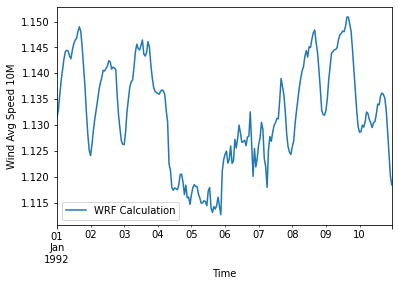

In [ ]:
df.plot(x='ds', y='rho_0')
plt.xlabel('Time')
plt.ylabel("Wind Avg Speed 10M")
plt.legend(['WRF Calculation'])
plt.show()

## Check the wrfout file

In [ ]:
!wget https://s3.us-east-2.amazonaws.com/wrfwindout.d03.1992-01-01/wrftest/wrfout_d03_1992-01-01_00_00_00

--2021-02-23 18:52:43--  https://s3.us-east-2.amazonaws.com/wrfwindout.d03.1992-01-01/wrftest/wrfout_d03_1992-01-01_00_00_00
Resolving s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)... 52.219.97.49
Connecting to s3.us-east-2.amazonaws.com (s3.us-east-2.amazonaws.com)|52.219.97.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146475424 (140M) [application/x-www-form-urlencoded]
Saving to: ‘wrfout_d03_1992-01-01_00_00_00’

wrfout_d03_1992-01- 100%[===================>] 139.69M  30.5MB/s    in 5.2s    

2021-02-23 18:52:49 (26.8 MB/s) - ‘wrfout_d03_1992-01-01_00_00_00’ saved [146475424/146475424]



In [ ]:
fn_out = "/content/wrfout_d03_1992-01-01_00_00_00"
ds_out = nc.Dataset(fn_out)
ds_out

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V3.2 MODEL
    START_DATE: 1991-12-30_23:20:00
    SIMULATION_START_DATE: 1991-08-30_00:00:00
    WEST-EAST_GRID_DIMENSION: 139
    SOUTH-NORTH_GRID_DIMENSION: 145
    BOTTOM-TOP_GRID_DIMENSION: 44
    DX: 2000.0
    DY: 2000.0
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 0
    DAMPCOEF: 0.01
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 2
    RA_LW_PHYSICS: 1
    RA_SW_PHYSICS: 1
    SF_SFCLAY_PHYSICS: 1
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 1
    CU_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 1
    SST_UPDATE: 1
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
    GFDDA_END_H: 0
    GRID_SFDDA: 0
    SGFDDA_INTERVAL_M: 0
    SGFDDA_END_H: 0
    SF_URBAN_PHYSICS: 1
    FEEDBACK: 0
    SMOOTH_OPTION: 2
    SWRAD_SCAT: 1.0
    W_DAMPING: 1
    MOIST_ADV_OPT: 1
    SCALAR_ADV_OPT: 1
    TKE_ADV_OPT: 1
    DIFF_6TH_OPT: 0
    DIFF_6TH_FACTOR: 0.12
    OBS_NU

In [ ]:
u = ds_out['U'][:]
u.shape

(4, 43, 144, 139)

In [ ]:
u[1, 2, 100, 120]

-7.9661336